# Práctica final NLP Bea Mora

## Datasets

Los datasets escogidos para los distintos ejercicios son los siguientes:
- **Reviews de Amazon**: Reviews de productos de Amazon clasificadas por categorías (libros, electrónica, automoción, ...). Las reviews contienen la calificación (número de estrellas) por lo que es perfecto para problemas de clasificación supervisada del sentimiento. Se recomienda trabajar con subsets de dichos datasets para evitar problemas de memoria y de desbalanceo de clases. Enlace: http://jmcauley.ucsd.edu/data/amazon/
- **Tweets**: Conjunto de tweets de diferentes personalidades. Los tweets están en crudo, esto es, contendrán enlaces, menciones, hashtags que convendrá normalizar u eliminar. Enlace: https://www.kaggle.com/speckledpingu/RawTwitterFeeds

# Ejercicio 2 : Análisis de Sentimiento

Implementación y evaluación de un modelo de análisis de sentimiento.

El objetivo principal es el de realizar un **modelo de clasificación binaria**. Se valorará positivamente comparar la variación en los resultados al usar **diferentes modelos**, al **modificar algún paso en la etapa de preprocesado** (stemming vs no stemming, p.ej.), así como la comparación de resultados utilizando o bien **modelos pre-entrenados** o modelos más simples (como VADER).

Se utilizará alguno de los datasets disponibles de **reviews de Amazon**.

Soluciones más avanzadas como por ejemplo modelos de clasificación multi-clase o basados en embeddings serán valorables.

# Importamos librerias

In [231]:
import os
import random
import pandas as pd
from num2words import num2words
import re

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import random
import numpy as np
import pandas as pd
#pd.set_option('display.max_colwidth', None) # para mostrar todo el contenido de una columna

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import  MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

# Cargamos los datos

Hemos elegir 5 categorias para realizar el estudio de los topics : baby, beauty, food, musical instruments and sports & outdoors.

In [2]:
df_Baby = pd.read_json('Baby_5.json', lines=True)
df_Beauty = pd.read_json('Beauty_5.json', lines=True)
df_Food = pd.read_json('Grocery_and_Gourmet_Food_5.json', lines=True)
df_Musical_Instruments = pd.read_json('Musical_Instruments_5.json', lines=True)
df_Sports_and_Outdoors = pd.read_json('Sports_and_Outdoors_5.json', lines=True)

In [6]:
df_Baby.iloc[8]

reviewerID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  A1ZSTU6RKY1JCL
asin                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [4]:
df_Baby.dropna(inplace=True)
df_Beauty.dropna(inplace=True)
df_Food.dropna(inplace=True)
df_Musical_Instruments.dropna(inplace=True)
df_Sports_and_Outdoors.dropna(inplace=True)


He realizado un histograma con el dataframe final que contiene los 10K primeros registros de cada subcategoría, pero la variable target está muy desbalanceada (de 50K, 42K son positivas y 8K son negativas).

El dataframe Musical_Instruments se compone de 10261, y no llegabamos a los 10K registros cogiendo los registros con reviews >y< 3, por lo que hemos cogido las reviews negativas de este dataset y las restantes 4550 de otro dataset más extenso como Sports_and_Outdoors.

In [7]:
df_Babyp = df_Baby[df_Baby['overall']>3].iloc[0:5000]
df_Babyn = df_Baby[df_Baby['overall']<3].iloc[0:5000]
df_Baby10 = pd.concat([df_Babyp[['reviewText', 'overall']] , df_Babyn[['reviewText', 'overall']] ])

df_Beautyp = df_Beauty[df_Beauty['overall']>3].iloc[0:5000]
df_Beautyn = df_Beauty[df_Beauty['overall']<3].iloc[0:5000]
df_Beauty10 = pd.concat([df_Beautyp[['reviewText', 'overall']] , df_Beautyn[['reviewText', 'overall']] ])

df_Foodp = df_Food[df_Food['overall']>3].iloc[0:5000]
df_Foodn = df_Food[df_Food['overall']<3].iloc[0:5000]
df_Food10 = pd.concat([df_Foodp[['reviewText', 'overall']] , df_Foodn[['reviewText', 'overall']] ])

df_Musical_Instrumentsp = df_Musical_Instruments[df_Musical_Instruments['overall']>3].iloc[0:5000]
df_Musical_Instrumentsn = df_Musical_Instruments[df_Musical_Instruments['overall']<3].iloc[0:450]
df_Musical_Instruments10 = pd.concat([df_Musical_Instrumentsp[['reviewText', 'overall']] , df_Musical_Instrumentsn[['reviewText', 'overall']] ])

df_Sports_and_Outdoorsp = df_Sports_and_Outdoors[df_Sports_and_Outdoors['overall']>3].iloc[0:5000]
df_Sports_and_Outdoorsn = df_Sports_and_Outdoors[df_Sports_and_Outdoors['overall']<3].iloc[0:9550]
df_Sports_and_Outdoors10 = pd.concat([df_Sports_and_Outdoorsp[['reviewText', 'overall']] , df_Sports_and_Outdoorsn[['reviewText', 'overall']] ])


Es dataset de Musical_instruments está bastante desbalanceado, y por eso cogemos reviews negativas de otros dataset para tener mitad de reviews positivas y mitad de reviews negativas

In [9]:
df_Musical_Instruments['overall'].value_counts()
# df_Musical_Instruments[df_Musical_Instruments['overall']<3].shape

5    6918
4    2080
3     771
2     249
1     216
Name: overall, dtype: int64

Juntamos los 5 datasets en uno único.

In [10]:
dfs = [df_Baby10, df_Beauty10, df_Food10,  df_Musical_Instruments10, df_Sports_and_Outdoors10]
df_Total = pd.concat(dfs)

Creamos las etiquetas para las reviews:    
- Una review numérica menor de 3 tiene una etiqueta negativa
- Una review numérica mayor de 3 tiene una etiqueta positiva

In [ ]:
# Creamos la función de etiquetado de reviews.
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    else:
        return 'pos'

In [13]:
df_Total['overall'] = df_Total.apply(lambda row: label_sentiment(row), axis=1)

In [236]:
# Verificamos el tamaño total de nuestro dataset
df_Total.shape

(50000, 2)

In [163]:
# Confirmamos que nuestro dataset está balanceado
df_Total['overall'].value_counts()

neg    25000
pos    25000
Name: overall, dtype: int64

# Separamos en train, validation y test

In [164]:
# Para estratificar necesitamos separa por la variable target
# Para esto creamos la variable GT - Ground truth
GT = df_Total['overall'].values

# Separamos para tener los tres set de train, test y val
Xtrain, X_test, ytrain, y_test = train_test_split(
    df_Total['reviewText'],
    df_Total['overall'],
    train_size=0.8,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify = GT
)

# Creamos de nuevo la variable GT2 para realizar la segunda separación
GT2 = ytrain.values

X_train, X_val, y_train, y_val = train_test_split(
    Xtrain,
    ytrain,
    train_size=0.85,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    stratify = GT2
)

print(f'Dimensiones del dataset de training: {X_train.shape}')
print(f'Dimensiones del dataset de validation: {X_val.shape}')
print(f'Dimensiones del dataset de test: {X_test.shape}')

Dimensiones del dataset de training: (34000,)
Dimensiones del dataset de validation: (6000,)
Dimensiones del dataset de test: (10000,)


# Prepocesado

Vamos a realizar 3 pasos principalmente: 
- Tokenización - cortar las cadenas en trozos de texto más pequeños, "tokens". En nuestro caso vamos a usar palabras.
- Normalization - Consiste en procesar el texto para que pueda ser procesado después por el modelo. Esto incluye, converter a minúscula/mayúscula, eliminar puntuación (esto podría indicarnos el final de frase, pero no nos aporta información adiccional sobre el contenido), convertir números a sus equivalentes palabras, lemmatizar(transformación de las palabras para quedarnos con la forma canónica de la palabra),eliminar espacios en blanco extra, eliminar stopwords (son las palabras que no contribuyen mucho al significado del texto, ya que tiene una frecuencia de aparición grande y eliminar sparse terms( ignorar términos que tienen una frecuencia muy baja - 1,2,3,5,10 veces - para poder realizar una mejor generalización y evitar overfitting.
- Noise removal, depende del framework de donde obtengamos nuestro corpus. Si tiene etiquetas HTML/XML , headers, extraer inforrmación de ficheros json o bases de datos, y expresiones regulares( por ejemplo eliminación de URL) .

En nuestro caso, primero hemos extraido la información del fichero .json a un dataframe de pandas. 
Ahora vamos a proceder a tokenizar y normalizar. 


Creamos varias funciones para realizar el preprocesado.

- La primera es para eliminar URLs.
- La segunda función es para lemmatizar los tokens. 
- La tercera es para separar cada token, en nuestro caso cada palabra del párrafo review, eliminando puntuación. Además confirmamos si hay números y los pasamos a letra y lemmatizamos. Para el caso del procesado he decicido eliminar palabras con menos de 2 caracteres de longitud, ya que este tipo de palabras están asociadas a preposiciones y determinantes.
- La cuarta para juntar todas las listas de palabras en una lista.  

Nota I: Uso las funciones de Carlos :)     
Nota II : Fichero de lemmatización obtenido de https://github.com/michmech/lemmatization-list

In [28]:
import re

def URL_removal(text):
    text = re.sub(r'http\S+', '', text)
    return text

In [29]:
X_train = X_train.apply(URL_removal)

In [32]:
# Función para lemmatizar las palabra. Necesitamos proporcionarle el fichero de lemmatización 
def get_lemmas_dict(data_path, lemmas_dict_file):
    lemmas_dict = {}
    with open(os.path.join(data_path, lemmas_dict_file), 'r', encoding='utf-8') as f:
        for line in f:
            (key, val) = line.split()
            lemmas_dict[str(val)] = key
    return lemmas_dict


# Convierte a minúsuclas, tokeniza y elimina palabras de 2 o menos carácteres
# la salida son tokens - cadenas unicode que no necesitan más procesado
def text_preproc(text):
    
    data_path = './'
    lemmas_dict_file = 'lemmatization-en.txt'
    lemmas_dict = get_lemmas_dict(data_path, lemmas_dict_file)    
    
    result=[]
   
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            if token.isdigit():
                token = num2words(token, lang='en')
            ltoken = lemmas_dict.get(token, token)
            result.append(ltoken)
  
    return result

# Esta función crea una lista de listas de tokens, cada sublista pertenece a un registro del dataframe
def all_text(l):
    texts = []
    for text in l:
        texts.append(text_preproc(text))
      
    return texts 

Utilizando el preprocesado del primer ejercicio, creamos una lista de listas.     
Pero para este ejercicio la función Tfidf necesita un dataframe de strings.

In [ ]:
# from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, stem_text
# CUSTOM_FILTERS = [remove_stopwords, stem_text]
# tokens = [preprocess_string(" ".join(doc), CUSTOM_FILTERS) for doc in tokens]

In [33]:
# aplicamos preprocesado a nuestro conjunto de train
words_text = all_text(X_train)

In [34]:
# convertimos a string
k = []
for i in range(len(words_text)):
    k.append( " ".join(words_text[i]))

In [35]:
# convertimos el string a dataframe de pandas.core.Series
df_text = pd.Series(data=k)

# Visualización de features para sentimientos positivos y negativos

In [240]:
idxn = []
idxp = []
for i in range(len(y_train)):
    if y_train.values[i] == 'neg':
        idxn.append(i)
    else:
        idxp.append(i)
       
       
idx_pos = np.array(idxp)
idx_neg = np.array(idxn)  

text_pos = np.array(words_text)[idx_pos.astype(int)]
text_neg = np.array(words_text)[idx_neg.astype(int)]

words_pos = ('\n'.join(' '.join(sub) for sub in text_pos))
li_pos = list(words_pos.split(' '))
words_neg = ('\n'.join(' '.join(sub) for sub in text_neg))
li_neg = list(words_neg.split(' '))

In [266]:
from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=100, max_words=150, background_color="black", width=900, height=500).generate(' '.join(text))
    plt.figure( figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

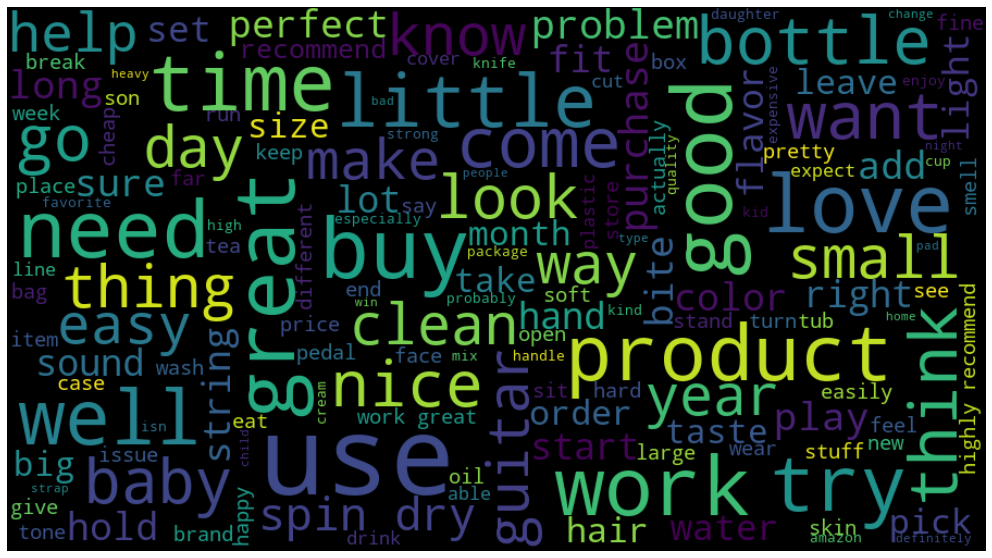

In [267]:
plot_word_cloud(li_pos)

Algunas palabras son : Great, use, good, preoduct, try, well, easy, need...

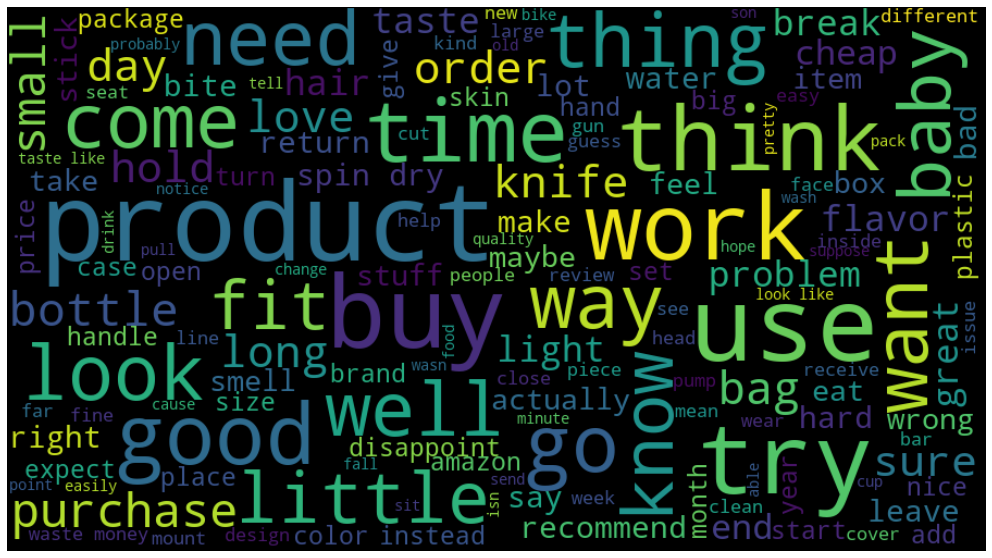

In [268]:
plot_word_cloud(li_neg)

Algunas palabras son : maybe, disappoint, problem, time, little, want, come ..      
Es interesante quue no hay especialmente palabras con connotación muy negativa para la nube de reviews negativas. 

# Extración de features 

Hay varias formas de extraer features, como Bag of words, Word2Vect, Doc2Vec o TF-IDF.
La extracción de features es necesaria para reducir atributos, en este caso tokens - palabras, y que ayudan a mejorar la velocidad y eficacion de los modelos.

TF_IDF contiene dos factores, TF y IDF. Multiplicando estos dos fáctores obtenemos el valor TF-IDF de una palabra. 
- TF - Term Frequency - asigna un peso a los tokens mas frecuentes que existen en el dataset. 
- IDF - Inverse document frequency - es el factor de escala que asigna un peso a los tokens menos frecunetes que existen en el dataset.
En definitiva, para los token más populares y más raros, este score es bajo en comparación al resto de tokens. De esta forma podemos eliminar estos tokens que no nos aportan información significativa. 

Los parámetros a ajustar son: 

**max_df** -- When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (lo que se puede conocer como stopwords).      
**min_df** -- When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.     
**max_features** -- If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.         
**ngram_range** -- The lower and upper boundary of the range of n-values for different n-grams to be extracted.For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams.


In [437]:
# Normalizamos cada TF por el numero de documentos que tienen ese token. 
tfidf = TfidfVectorizer(
    max_df=0.95, # ignore terms que aparecen mas del 95% 
    min_df=5, # ignore terms que aparecen en menos de 5 documents
    max_features= 5000,
    ngram_range=(1, 2)
)

tfidf.fit(df_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=5000,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [438]:
# Mostramos algunos tokens del vocabulario
print(list(tfidf.vocabulary_.items())[:20])

[('recieved', 3487), ('gun', 1927), ('today', 4472), ('day', 1066), ('order', 2992), ('good', 1807), ('completely', 865), ('smash', 3942), ('piece', 3135), ('open', 2974), ('package', 3030), ('damage', 1045), ('bubble', 514), ('wrap', 4953), ('ship', 3829), ('contact', 911), ('company', 852), ('ask', 184), ('photo', 3125), ('say', 3713)]


In [439]:
# Verificamos el tamaño de nuestro vocabulario
print(len(tfidf.vocabulary_))

5000


Aplicamos la transformacion de la vectorizacion al dataset de training

In [440]:
X_train_ = tfidf.transform(df_text)

Vamos a analizar cuales son las 15 palabras con mayor y menor TF-IDF

In [68]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=tfidf.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 15:
               tfidf
vocal       0.320833
pod         0.297525
compliment  0.292847
studio      0.286649
record      0.270666
ton         0.260713
mic         0.259831
fantastic   0.253650
beat        0.244751
acoustic    0.244504

Top 10 words with lowest TF_IDF in the review 15:
              tfidf
fantastic  0.253650
beat       0.244751
acoustic   0.244504
dollar     0.238953
complaint  0.233445
tell       0.194508
people     0.184310
sound      0.182708
price      0.143739
use        0.102026


TF_IDF es una medida estática que puede variar entre 0 y 1.
- TF_IDF alto - próximo a 1, indica términos que raramente aparecen. No se repiten en los documents.
- TF_IDF bajo - próximo a 0, indica términos que son muy populares y que aparecen en muchos documents. 

Como curiosidad destacaría que para valores bajo de TF_IDF, indicando palabras que aparacen mucho, está 'complaint'. Sin embargo de entre los términos con TF_IDF alto, indicando palabras con poca frecuencia, está 'compliment'.

## Cálculo de importancia de features

Esta métrica sirver para evaluar la importancia de los features. Nos ayuda a ver los términos mas usados en el dataset. Nos puede servir para ver si el dataset está desbalanceado y observar la naturaleza de los términos.

Nos sirve para encontrar las features con el valor más alto de chi cuadrado, que son más frecuentes e el dataset en relación con las clases de clasificación (en nuestro caso positivo o negativo). Dicho de otra forma, nos dice si la relación entre la frecuencia de un término específico y la frecuencia de una clase específica, es independiente. 



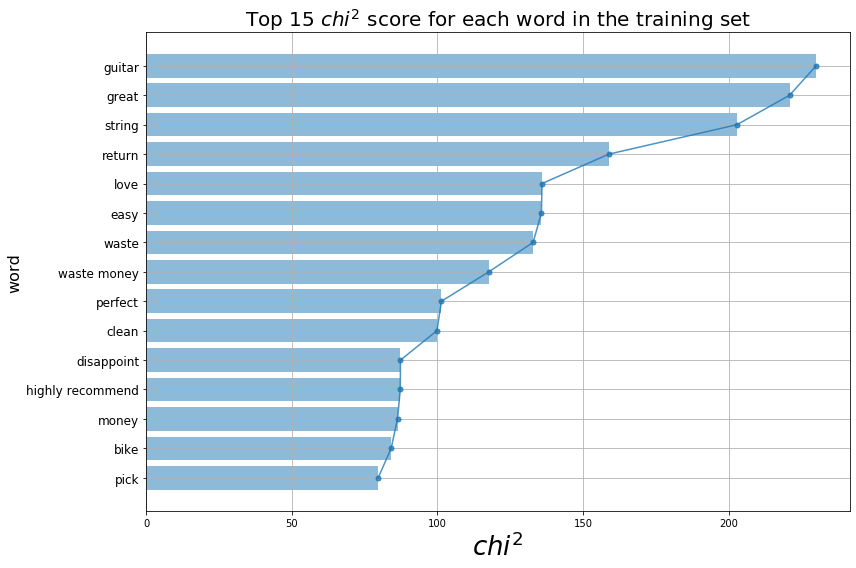

In [348]:
# Calculamos el chi-squared score para cada token en el dataset de training
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(tfidf.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$ chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $ chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Como el data set está balanceado, no vemos términos que especialmente puedan denotar una review positiva o negativa.     
Por ejemplo, **great** es un adjetivo que solo indica la intensidad de otro término. Sí es interesante la palabra **return**, que normalmente puede estar asociado a una review negativa.     
Después **dissapoint** y **highly recommend** tienen un score muy parecido, por lo que deben ser terminos que se usan mucho en las reviews negativas y positivas respectivamente.

# Preprocesamiento para los dataset de validación y test

In [349]:
X_val = X_val.apply(URL_removal)
words_val = all_text(X_val)

v = []
for i in range(len(words_val)):
    v.append( " ".join(words_val[i]))

df_val = pd.Series(data=v)

In [350]:
X_test= X_test.apply(URL_removal)
words_test = all_text(X_test)

t = []
for i in range(len(words_test)):
    t.append( " ".join(words_test[i]))

df_test = pd.Series(data=t)

In [441]:
X_val_ = tfidf.transform(df_val)
X_test_ = tfidf.transform(df_test)

In [395]:
## Dataset sin preprocesado
# X_val = X_val.apply(URL_removal)
# X_test= X_test.apply(URL_removal)

# X_val_ = tfidf.transform(X_val)
# X_test_ = tfidf.transform(X_test)

# Modelos

## 1. Regresión Logística

El módelo de regresión logística es un modelo bastante usado como inicio a un resultado en NLP.

Vamos a realizar una búsqueda manual de parámetros que optimizan nuestro modelo. También se podria usar Gridsearch, pero ya que hemos separado el dataset entero en train, validation y test, vamos a realizarlo de forma manual(de cualquier forma, probé con gridsearch y salió el mismo resultado :)).  

El parámetro que vamos a analizar es C. Este valor representa el inverso del valor de la regularización. Cuanto más pequeño sea este valor, mayour regulación se está aplicando, siendo regulación una medida que ayuda a generalizar mejor, sin fijarse sólo en los datos del dataset de training, lo que evita overfitting.

Otros parámetros:       
Solver - algoritmo usado para la optimización del problema. 'lbfgs' . He probado con 'liblinear' y 'saga' sin haber gran diferencia.      
max_iter - es necesario un número alto para que el solver pueda converger. Cuantos más datos tengamos más alto tendrá que ser este valor.


### Búsqueda de hyperparámetros

In [275]:
c_params = [0.01, 0.1, 1, 10, 100, 1000]

acc_table = pd.DataFrame(columns = ['c_params', 'Acc_train' , 'Acc_val'])
acc_table['c_params'] = c_params

j = 0
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    lr_y_train = lr.predict(X_train_)
    lr_y_val = lr.predict(X_val_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_val, lr_y_val)))
    
    acc_table.iloc[j,1] = accuracy_score(y_train, lr_y_train)
    acc_table.iloc[j,2] = accuracy_score(y_val, lr_y_val)
    j += 1

acc_table

Accuracy for C=0.01: 0.811
Accuracy for C=0.1: 0.8398333333333333
Accuracy for C=1: 0.8563333333333333
Accuracy for C=10: 0.8545
Accuracy for C=100: 0.8536666666666667


C:\Users\pablo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for C=1000: 0.8528333333333333
Accuracy for C=10000: 0.8528333333333333


C:\Users\pablo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,c_params,Acc_train,Acc_val
0,0.01,0.824059,0.811
1,0.10,0.854471,0.839833
2,1.00,0.882118,0.856333
3,10.00,0.893471,0.8545
4,100.00,0.894765,0.853667
5,1000.00,0.894765,0.852833
6,10000.00,0.894882,0.852833


El accuracy más alto para el set de validación es para C = 1.00.     
Ahora vamos a ejecutar el modelo con este parámetro. 

### Ejecutamos el modelo con los óptimos hyperparametros

In [435]:
lr = LogisticRegression(C=1, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)

lr_y_train = lr.predict(X_train_)
lr_y_test = lr.predict(X_test_)

In [436]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, lr_y_test)))
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))
print('\nClassification report:\n{}'.format(classification_report(y_test, lr_y_test)))

print('Accuracy score Training:{:.3f}'.format(accuracy_score(y_train, lr_y_train)))
print('Accuracy score Test:{:.3f}'.format(accuracy_score(y_test, lr_y_test)))

Confussion matrix:
[[4386  614]
 [ 637 4363]]
---------------
[['TN' 'FP']
 ['FN' 'TP']]

Classification report:
              precision    recall  f1-score   support

         neg       0.87      0.88      0.88      5000
         pos       0.88      0.87      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy score Training:0.906
Accuracy score Test:0.875


## 2. Naive Bayes

NB es un clasificador probabilistoc que se basa en las propiedades del teorema de Bayes asumiendo una fuerte independencia entre las features. Una de las ventajas de este clasificador es que requiere de un dataset pequeño de training para calcular el modelo de predicción. 

Para este modelo vamos a analizar el parámetro alpha que está relacionado con la capacidad del modelo para clasificar tokens que no ha visto.

### Búsqueda de hyperparámetros

In [282]:
alpha_params = [0.001, 0.01, 0.1, 1, 10]

acc_tablemnb = pd.DataFrame(columns = ['alpha_params', 'Acc_train' , 'Acc_val'])
acc_tablemnb['alpha_params'] =alpha_params

j = 0
for c in alpha_params:
    mnb = MultinomialNB(alpha=c)
    mnb.fit(X_train_, y_train)
    
    mnb_y_train = mnb.predict(X_train_)
    mnb_y_val = mnb.predict(X_val_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_val, mnb_y_val)))
    
    acc_tablemnb.iloc[j,1] = accuracy_score(y_train, mnb_y_train)
    acc_tablemnb.iloc[j,2] = accuracy_score(y_val, mnb_y_val)
    j += 1

acc_tablemnb

Accuracy for C=0.001: 0.8353333333333334
Accuracy for C=0.01: 0.8353333333333334
Accuracy for C=0.1: 0.8356666666666667
Accuracy for C=1: 0.8358333333333333
Accuracy for C=10: 0.8353333333333334


,alpha_params,Acc_train,Acc_val
0,0.001,0.850441,0.835333
1,0.010,0.850412,0.835333
2,0.100,0.850647,0.835667
3,1.000,0.851412,0.835833
4,10.000,0.848647,0.835333


La verdad es que no hay mucha diferencia. Vamos a escoger alpha = 1

### Ejecutamos el modelo con los óptimos hyperparametros

In [419]:
mnb = MultinomialNB(alpha=1)
mnb.fit(X_train_, y_train)

mnb_y_train = mnb.predict(X_train_)
mnb_y_test = mnb.predict(X_test_)

In [420]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, mnb_y_test)))
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

print('\nClassification report:\n{}'.format(classification_report(y_test, mnb_y_test)))
print('Accuracy score Training:{:.3f}'.format(accuracy_score(y_train, mnb_y_train)))
print('Accuracy score Test:{:.3f}'.format(accuracy_score(y_test, mnb_y_test)))

Confussion matrix:
[[4417  583]
 [ 778 4222]]
---------------
[['TN' 'FP']
 ['FN' 'TP']]

Classification report:
              precision    recall  f1-score   support

         neg       0.85      0.88      0.87      5000
         pos       0.88      0.84      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy score Training:0.913
Accuracy score Test:0.864


## 3.Random Forest

Random Forest es una combinación de múltiples decisiontrees que escoge muestras aleatorias del training set para realizar las clasificaciones. Después cuenta los votos de cada decisiontree para tomar una decisión final.

El hyperparametro a tunear en este caso es el número de decisiontrees. 

### Búsqueda de hyperparámetros

In [305]:
N_estimators = [100, 200, 500, 1000]

acc_tablerf = pd.DataFrame(columns = ['N_estimators', 'Acc_train' , 'Acc_val'])
acc_tablerf['N_estimators'] = N_estimators

j = 0
for c in N_estimators:
    rf = RandomForestClassifier(n_estimators=c, random_state=0)  
    rf.fit(X_train_, y_train)
    
    rf_y_train = rf.predict(X_train_)
    rf_y_val = rf.predict(X_val_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_val, rf_y_val)))
    
    acc_tablerf.iloc[j,1] = accuracy_score(y_train, rf_y_train)
    acc_tablerf.iloc[j,2] = accuracy_score(y_val, rf_y_val)
    j += 1

acc_tablerf

Accuracy for C=100: 0.8196666666666667
Accuracy for C=200: 0.8236666666666667
Accuracy for C=500: 0.825
Accuracy for C=1000: 0.8271666666666667


,N_estimators,Acc_train,Acc_val
0,100,0.999647,0.819667
1,200,0.999647,0.823667
2,500,0.999647,0.825
3,1000,0.999647,0.827167


El mejor resultado para el dataset de validación se optiene para N_estimator = 1000. 
Aunque los resultados no son mucho mejores:      
N_estimator = 100 --> Precision = 0.82 ; Recall = 0.83 ; f1-score = 0.83  
N_estimator = 1000 --> Precision = 0.83 ; Recall = 0.83 ; f1-score = 0.83    
y no en tanto el tiempo de ejecución es mucho mayor, por lo que vamos a dejarlo en N_estimator = 100.

### Ejecutamos el modelo con los óptimos hyperparámetros

In [400]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)  
rf.fit(X_train_, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [401]:
rf_y_train = rf.predict(X_train_)
rf_y_test = rf.predict(X_test_)

In [402]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, rf_y_test)))
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

print('\nClassification report:\n{}'.format(classification_report(y_test, rf_y_test)))
print('Accuracy score Training:{:.3f}'.format(accuracy_score(y_train, rf_y_train)))
print('Accuracy score Test:{:.3f}'.format(accuracy_score(y_test, rf_y_test)))

Confussion matrix:
[[4162  838]
 [1290 3710]]
---------------
[['TN' 'FP']
 ['FN' 'TP']]

Classification report:
              precision    recall  f1-score   support

         neg       0.76      0.83      0.80      5000
         pos       0.82      0.74      0.78      5000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

Accuracy score Training:0.999
Accuracy score Test:0.787


## Fully connected Neural Network

### Preparamos los datos para la red

In [316]:
# Hago una copia de las variables target
y_train_2 = y_train
y_test_2 = y_test
y_val_2 = y_val

# Convierto la variable target a númerica
y_train_2 = y_train_2.apply(lambda x: 1 if x == 'neg' else 0)
y_test_2 = y_test_2.apply(lambda x: 1 if x == 'neg' else 0)
y_val_2 = y_val_2.apply(lambda x: 1 if x == 'neg' else 0)

# Convierto la variable categórica a one-hot
from keras.utils import np_utils
y_train_3 = np_utils.to_categorical(y_train_2, 2)
y_test_3 = np_utils.to_categorical(y_test_2, 2)
y_val_3 = np_utils.to_categorical(y_val_2, 2)

In [377]:
# transformo los dataset para que se puedan introducir en la red neuronal. Devuelve una matriz densa
x_train_2 = tfidf.transform(df_text).todense()
x_val_2 = tfidf.transform(df_val).todense()
x_test_2 = tfidf.transform(df_test).todense()

In [403]:
# # Dataset sin preprocesado
# x_train_2 = tfidf.transform(X_train).todense()
# x_val_2 = tfidf.transform(X_val).todense()
# x_test_2 = tfidf.transform(X_test).todense()

### Ejecutar el modelo

In [404]:
nb_classes = 2
from keras.layers import Activation, Dense, Dropout

model = Sequential()
model.add(Dense(1000,input_shape= (5000,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

print (model.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 1000)              2501000   
_________________________________________________________________
activation_45 (Activation)   (None, 1000)              0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 500)               500500    
_________________________________________________________________
activation_46 (Activation)   (None, 500)               0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 50)              

In [405]:
model.fit(x_train_2, y_train_3, validation_data=(x_val_2, y_val_3), batch_size=64, epochs=20 ,verbose=1)

Epoch 1/20
532/532 [==============================] - 11s 21ms/step - loss: 0.3444 - accuracy: 0.8492 - val_loss: 0.2768 - val_accuracy: 0.8820
Epoch 2/20
532/532 [==============================] - 11s 20ms/step - loss: 0.2434 - accuracy: 0.9026 - val_loss: 0.2722 - val_accuracy: 0.8808
Epoch 3/20
532/532 [==============================] - 10s 20ms/step - loss: 0.1746 - accuracy: 0.9352 - val_loss: 0.2841 - val_accuracy: 0.8845
Epoch 4/20
532/532 [==============================] - 10s 19ms/step - loss: 0.0878 - accuracy: 0.9702 - val_loss: 0.4093 - val_accuracy: 0.8750
Epoch 5/20
532/532 [==============================] - 11s 20ms/step - loss: 0.0512 - accuracy: 0.9814 - val_loss: 0.4717 - val_accuracy: 0.8777
Epoch 6/20
532/532 [==============================] - 10s 20ms/step - loss: 0.0321 - accuracy: 0.9890 - val_loss: 0.5112 - val_accuracy: 0.8825
Epoch 7/20
532/532 [==============================] - 11s 20ms/step - loss: 0.0270 - accuracy: 0.9916 - val_loss: 0.5231 - val_accuracy:

In [406]:
# Predecir a qué clase pertenece una review
DNN_y_train = model.predict_classes(x_train_2,batch_size=64)
DNN_y_test = model.predict_classes(x_test_2,batch_size=64)

In [407]:
# convertir a númerico para calcular la matrix de confusión
DNN_y_train = np.where(DNN_y_train > 0, 'neg', 'pos')
DNN_y_test = np.where(DNN_y_test > 0, 'neg', 'pos')

In [408]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, DNN_y_test)))
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

print('\nClassification report:\n{}'.format(classification_report(y_test, DNN_y_test)))
print('Accuracy score Training:{:.3f}'.format(accuracy_score(y_train, DNN_y_train)))
print('Accuracy score Test:{:.3f}'.format(accuracy_score(y_test, DNN_y_test)))

Confussion matrix:
[[4480  520]
 [ 630 4370]]
---------------
[['TN' 'FP']
 ['FN' 'TP']]

Classification report:
              precision    recall  f1-score   support

         neg       0.88      0.90      0.89      5000
         pos       0.89      0.87      0.88      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.88     10000
weighted avg       0.89      0.89      0.88     10000

Accuracy score Training:1.000
Accuracy score Test:0.885


# Conclusiones    

Contamos con un dataset de 50K reviews donde hemos buscado el mismo número de reviews positivas que negativas, por lo que nos aseguramos de que el dataset está balanceado.

Vamos a probar los modelos, sin preprocesado (solo eliminando URLs) y con preprocesado. Dentro de la opción de preprocesado, vamos a jugar con el tamaño del vocabulario y si usamos una sola palabra o usamos también combinaciones de dos palabras.

Inicialmente hice varias pruebas cambiando parámetros en tfidf y probando con LR que es el classificador más rápido y sorprendemente obtiene performance más alto. 

Los resultados de los clasificadores es bastante alto en general, siendo LR (logistic regression), uno de los preferidos por sus buenos resultados y simplicidad. Me sorprende que NB obtenga un valor más bajo, ya que en la teoría hay muchos white papers que muestran resultados eficaces para este tipo de clasificador.
Como tercera opción elegimos RF, por ser un modelo que proporciona consistencia ya que el resultado está dado en base a al resultado de varios clasificadores. Este clasificador se muestra estable frente a los cambios de parámetros realizados, excepto por el hecho de usar datos preprocesados o no. 
Por último queria usar un modelo de deep learning. Hay muchos tipos de estructura de red neuronal que podíamos haber usado, y aunque sabemos que LSTM funciona bien, necesitaba un preprocesado de datos adicional y hemos tenido la oportunidad de probar esta estructua en el ejercio 3, por lo que he escogido una estructura simple de 3 dense layers, antes de la clasificación.

Aplicando la clasificación sin preprocesado el rendimiento en general de los clasificadores es peor, excepto para el caso de la red neuronal que mejora en 0.02, lo cual me sorprende! pero tal vez la red neural tiene mas capacidad para aprender sobre datos en bruto.

Para un vocabulario de 2500 tokens, trabajar con 1-grams y 2-grams, sólo muestra una pequeña mejoría de 0.01 para el modelo de redes neuronales. 

El aumentar el vocabuliro al doble, 5000 tokens, mejora el rendimiento de todos los modelos en 0.01 excepto para Random Forest que permanece constante para las clasificaciones cuando los datos de entrada están preprocesados.

En general, los resultados son bastante altos, simplemente realizando un preprocesado y un mínimo tuneado de los algoritmos, excepto para el caso de la red neuronal que por tiempo no hemos podido tunear.

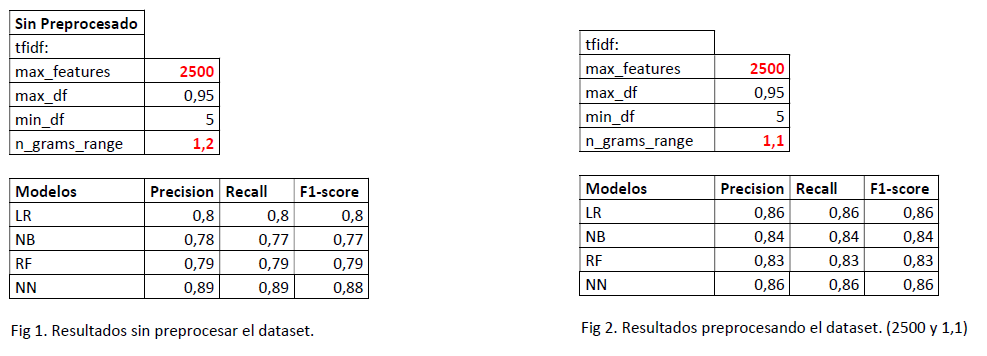
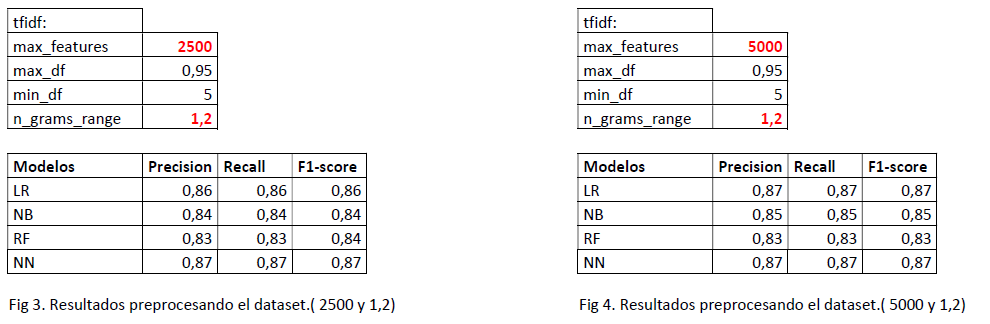

**Retos y limitaciones:** 
- El preprocesado necesario para que los datos trabajen con los modelos.
- La limitación de tiempo para probar modelos más complejos
- ¿Cómo se podria añadir información de emoticonos?
- Aplicar un corrector que asegure la semántica de los tokens

# Trabajo futuro

- Realizar un clasificador de 3 clases: positivo, negativo y neutro
- Probar módelos más complejos
- Realizar una optimización más exhaustiva tanto de TF-IDF como para los modelos
- Probar con un modelo SVM
- Evaluar los modelos usando word embedding( EJ: https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456)
- Probar resultados de Vader